In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/bitcoin-price-dataset/bitcoin_2017_to_2023.csv')

In [4]:
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [ ]:
# Visualize the 'volume' prices over time (assuming there is an implicit date ordering)
df['volume'].plot(figsize=(10, 6))
plt.title('Bitcoin Volume Price Over Time')
plt.ylabel('Volume Price')
plt.show()


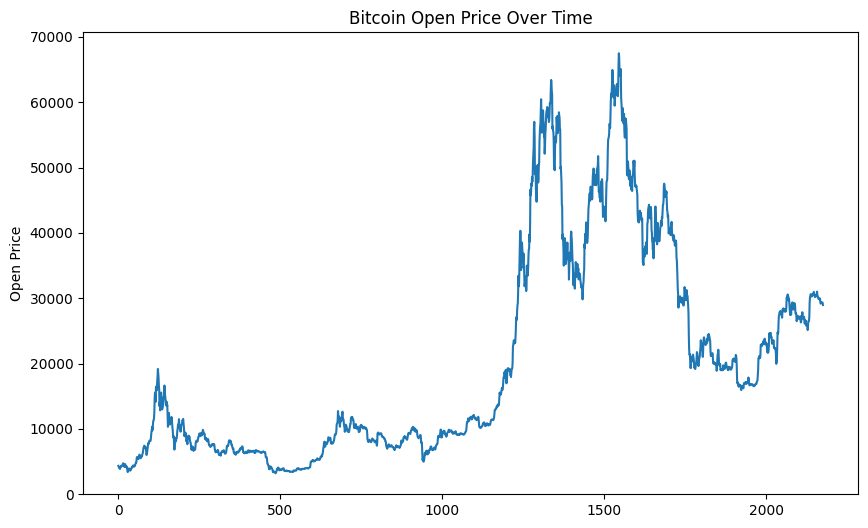

In [15]:
# Visualize the 'open' prices over time (assuming there is an implicit date ordering)
df['open'].plot(figsize=(10, 6))
plt.title('Bitcoin Open Price Over Time')
plt.ylabel('Open Price')
plt.show()


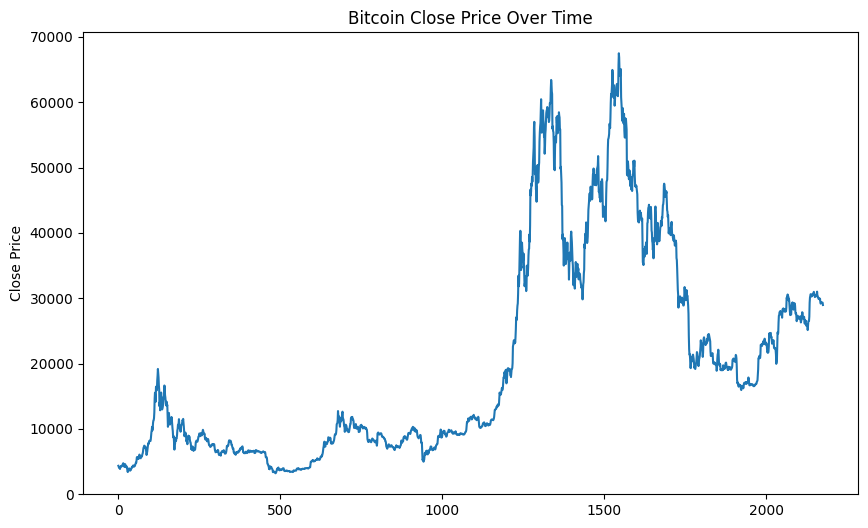

In [16]:
# Visualize the 'close' prices over time (assuming there is an implicit date ordering)
df['close'].plot(figsize=(10, 6))
plt.title('Bitcoin Close Price Over Time')
plt.ylabel('Close Price')
plt.show()


In [5]:
! pip install prophet

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

def prepare_data_for_prophet(stock_data):
    if not isinstance(stock_data, pd.Series):
        raise ValueError("stock_data must be a Pandas Series")

    # Scaling the target variable
    scaler = MinMaxScaler()
    stock_data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1)).flatten()

    # Split into training and testing sets, using the last 6 months for testing
    test_size = 126  # Assuming 21 trading days per month, 6 months = 21 * 6
    train_data, test_data = stock_data_scaled[:-test_size], stock_data_scaled[-test_size:]

    # Prepare Prophet DataFrame for training data
    train_df = pd.DataFrame({'ds': stock_data.index[:-test_size], 'y': train_data})
    
    return train_df, test_data, scaler

def process_stock_data_prophet(close_prices):
    print("Processing close prices for Prophet model...")

    # Prepare data
    train_df, test_data, scaler = prepare_data_for_prophet(close_prices)

    # Initialize Prophet model
    model = Prophet()

    # Fit the model
    model.fit(train_df)

    # Create a DataFrame for future predictions (the length of test data + train data)
    future = model.make_future_dataframe(periods=len(test_data))

    # Make predictions
    forecast = model.predict(future)

    # Extract predicted data for the last 'test_size' entries
    forecasted_data = forecast['yhat'][-len(test_data):]

    # Inverse the scaling for predictions and actual test data
    predictions_inverse = scaler.inverse_transform(forecasted_data.values.reshape(-1, 1)).flatten()
    test_data_inverse = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()

    # Evaluate the model
    mse = mean_squared_error(test_data_inverse, predictions_inverse)
    mae = mean_absolute_error(test_data_inverse, predictions_inverse)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data_inverse, predictions_inverse)

    print(f"""
    Evaluation Metrics for close prices:
    Mean Squared Error (MSE): {mse}
    Mean Absolute Error (MAE): {mae}
    Root Mean Squared Error (RMSE): {rmse}
    R² Score: {r2}
    """)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data_inverse, color='blue', label='Actual')
    plt.plot(predictions_inverse, color='red', label='Predicted')
    plt.title('Close Price Prediction with Prophet')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Example usage
# Assuming you have a DataFrame `df` with a 'close' column containing stock close prices:
# process_stock_data_prophet(df['close'])



Processing close prices for Prophet model...


07:40:26 - cmdstanpy - INFO - Chain [1] start processing
07:40:26 - cmdstanpy - INFO - Chain [1] done processing



    Evaluation Metrics for close prices:
    Mean Squared Error (MSE): 40.46316802180576
    Mean Absolute Error (MAE): 5.387259799180484
    Root Mean Squared Error (RMSE): 6.361066578947728
    R² Score: -0.3551962137060445
    


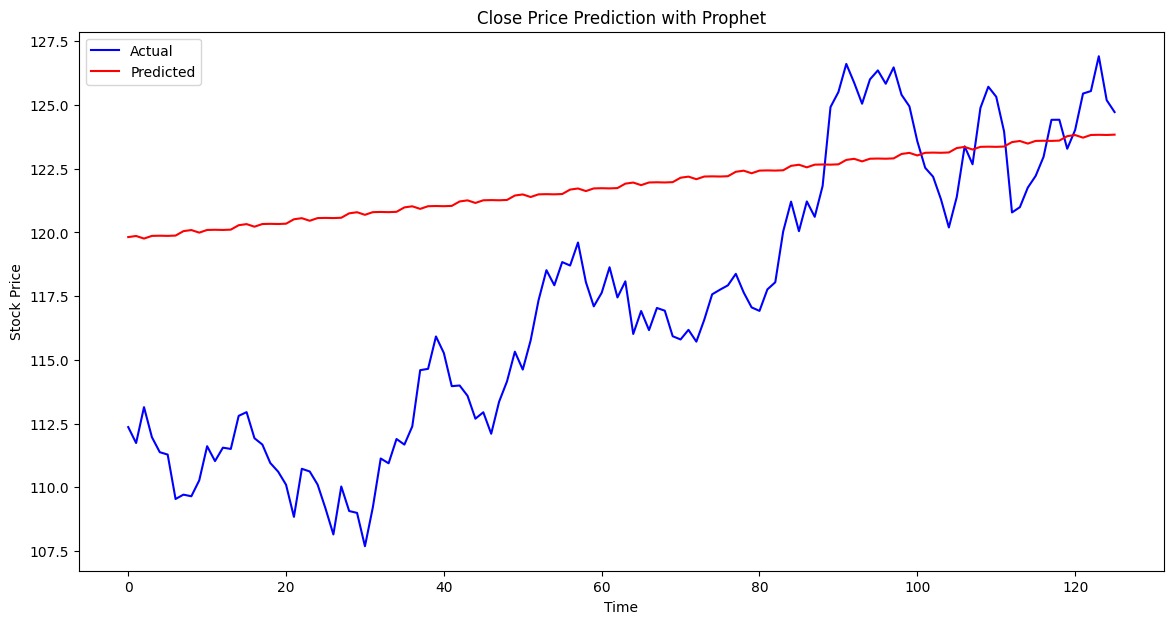

In [10]:
# Example usage with random data
dates = pd.date_range(start='2020-01-01', periods=500, freq='D')
close_prices = pd.Series(np.random.randn(500).cumsum() + 100, index=dates)

process_stock_data_prophet(close_prices)

In [7]:
# import pandas as pd
# from prophet import Prophet

# # Rename your columns to match Prophet's expected input
# df_prophet = df.rename(columns={'timestamp': 'ds', 'close': 'y'})

# # Ensure the timestamp column is in datetime format
# df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# # Initialize the Prophet model
# model = Prophet()

# # Fit the model
# model.fit(df_prophet)

# # Make a future dataframe (e.g., predict for the next 30 days)
# future = model.make_future_dataframe(periods=30)

# # Predict future values
# forecast = model.predict(future)

# # Plot the forecast
# model.plot(forecast)


In [8]:
# Example: Resampling to daily data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.resample('D', on='timestamp').mean().reset_index()

In [9]:
future = model.make_future_dataframe(periods=7)  # Predict for the next week


In [10]:
model = Prophet(changepoint_prior_scale=0.01)  # Example of reducing changepoint sensitivity


In [11]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)


09:59:22 - cmdstanpy - INFO - Chain [1] start processing
09:59:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


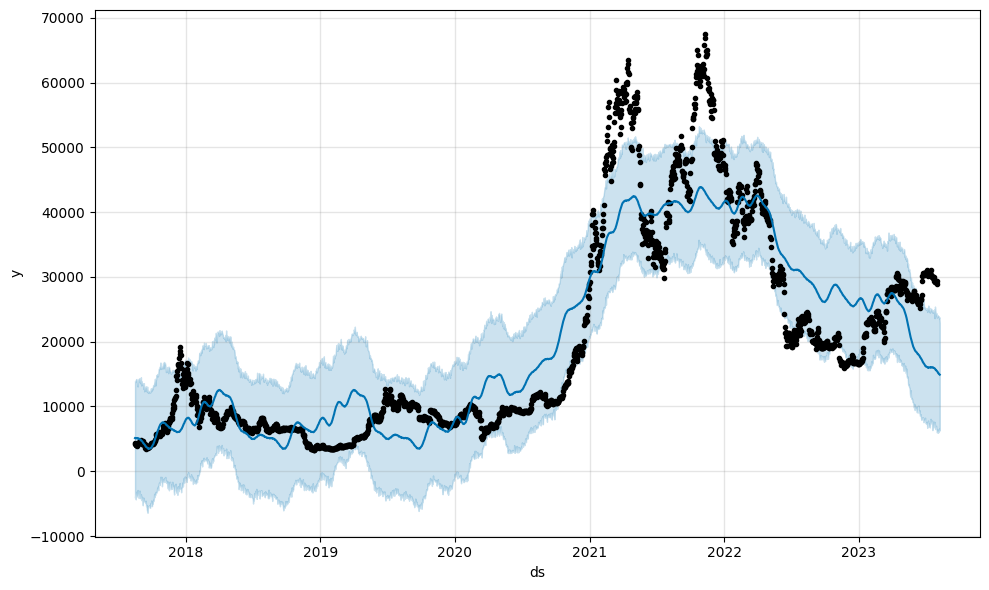

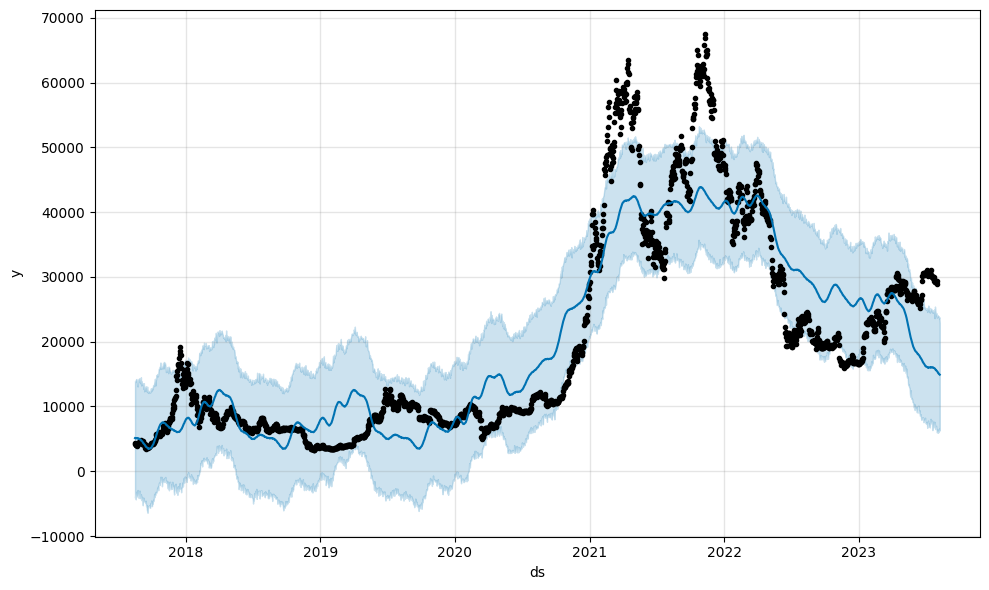

In [14]:
import pandas as pd
from prophet import Prophet

# Example: Resampling to daily data if your data is minute-level
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.resample('D', on='timestamp').mean().reset_index()

# Rename columns for Prophet
df_prophet = df.rename(columns={'timestamp': 'ds', 'close': 'y'})

# Initialize the Prophet model with fewer components
model = Prophet(changepoint_prior_scale=0.01)

# Fit the model
model.fit(df_prophet)

# Limit future predictions
future = model.make_future_dataframe(periods=7)  # Predict for the next week

# Predict future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
